In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/realwaste.zip


Archive:  /content/drive/MyDrive/realwaste.zip
797f4fca27a3a85e4c27131cdb7d9a9a5d72c494
   creating: realwaste-main/
  inflating: realwaste-main/README.md  
   creating: realwaste-main/RealWaste/
   creating: realwaste-main/RealWaste/Cardboard/
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_1.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_10.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_100.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_101.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_102.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_103.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_104.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_105.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_106.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_107.jpg  
  inflating: realwaste-main/RealWaste/Cardboard/Cardboard_108.jpg  
  inflatin

In [3]:
# ===============================
# 1. GEREKLİ KÜTÜPHANELER
# ===============================
import os
import shutil
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [5]:
# ===============================
# 2. VERİ SETİNİ TRAIN / VAL / TEST AYIRMA
# ===============================
base_dir = "realwaste-main/RealWaste"
output_dir = "realwaste_split"

os.makedirs(output_dir, exist_ok=True)

for cls in os.listdir(base_dir):
    cls_path = os.path.join(base_dir, cls)
    if not os.path.isdir(cls_path):
        continue

    images = os.listdir(cls_path)
    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

    for split, img_list in [("train", train_imgs), ("val", val_imgs), ("test", test_imgs)]:
        split_dir = os.path.join(output_dir, split, cls)
        os.makedirs(split_dir, exist_ok=True)
        for img in img_list:
            shutil.copy(os.path.join(cls_path, img), os.path.join(split_dir, img))

print("Veri seti hazır")


Veri seti hazır


In [6]:
# ===============================
# 3. DATA AUGMENTATION (DERS DÜZEYİ)
# ===============================
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

train_dataset = datasets.ImageFolder("realwaste_split/train", transform=transform_train)
val_dataset   = datasets.ImageFolder("realwaste_split/val", transform=transform_test)
test_dataset  = datasets.ImageFolder("realwaste_split/test", transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = train_dataset.classes
num_classes = len(class_names)


In [ ]:
# ===============================
# 4. MODEL (RESNET18 - TRANSFER LEARNING)
# ===============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights="IMAGENET1K_V1")

# Önceki katmanları dondur
for param in model.parameters():
    param.requires_grad = False

# Son katmanı değiştir
model.fc = nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 192MB/s]


In [8]:
# ===============================
# 5. MODEL EĞİTİMİ
# ===============================
epochs = 10

for epoch in range(epochs):
    model.train()
    correct, total, running_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{epochs}] - Loss: {running_loss:.4f} - Accuracy: {train_acc:.2f}%")


Epoch [1/10] - Loss: 162.4966 - Accuracy: 47.34%
Epoch [2/10] - Loss: 108.5904 - Accuracy: 66.05%
Epoch [3/10] - Loss: 93.3773 - Accuracy: 70.60%
Epoch [4/10] - Loss: 86.4557 - Accuracy: 72.07%
Epoch [5/10] - Loss: 80.9001 - Accuracy: 74.15%
Epoch [6/10] - Loss: 76.3749 - Accuracy: 74.45%
Epoch [7/10] - Loss: 74.4672 - Accuracy: 75.08%
Epoch [8/10] - Loss: 72.7708 - Accuracy: 76.56%
Epoch [9/10] - Loss: 68.5591 - Accuracy: 77.01%
Epoch [10/10] - Loss: 68.5779 - Accuracy: 76.83%


In [10]:
# ===============================
# 6. TEST + METRİKLER
# ===============================
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))



Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.71      0.79      0.74        70
      Food Organics       0.77      0.94      0.85        62
              Glass       0.88      0.67      0.76        63
              Metal       0.66      0.82      0.73       119
Miscellaneous Trash       0.61      0.44      0.51        75
              Paper       0.90      0.75      0.82        75
            Plastic       0.73      0.65      0.69       139
      Textile Trash       0.66      0.83      0.73        48
         Vegetation       0.91      0.92      0.92        66

           accuracy                           0.74       717
          macro avg       0.76      0.76      0.75       717
       weighted avg       0.75      0.74      0.74       717



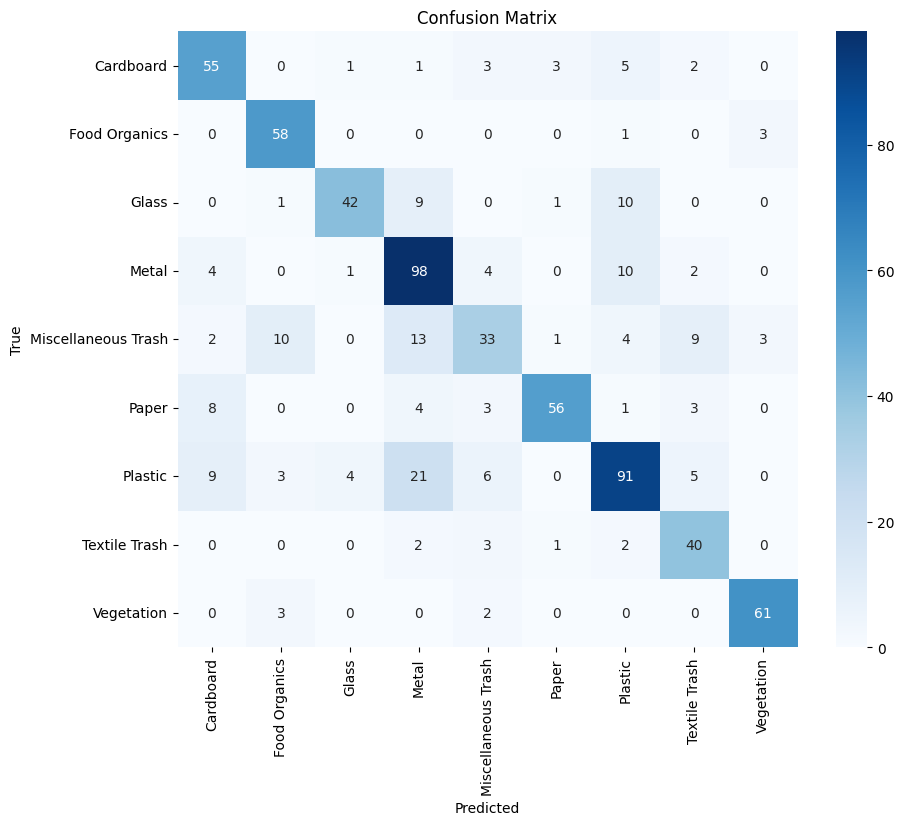

In [11]:
# ===============================
# 7. CONFUSION MATRIX
# ===============================
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [17]:
torch.save(model.state_dict(), "realwaste_resnet18.pth")
print("Model başarıyla kaydedildi ✅")


Model başarıyla kaydedildi ✅


In [15]:
!pip install gradio


In [19]:
import gradio as gr
import torch
import torchvision.transforms as transforms
from torchvision import models
from torch import nn
from PIL import Image
import numpy as np
import plotly.graph_objects as go
from datetime import datetime

# ===============================
# MODELİ YÜKLE
# ===============================
class_names = [
    'Cardboard',
    'Food Organics',
    'Glass',
    'Metal',
    'Miscellaneous Trash',
    'Paper',
    'Plastic',
    'Textile Trash',
    'Vegetation'
]

# Türkçe karşılıklar
turkish_names = {
    'Cardboard': '📦 Karton',
    'Food Organics': '🍎 Organik Atık',
    'Glass': '🥤 Cam',
    'Metal': '🥫 Metal',
    'Miscellaneous Trash': '🗑️ Diğer Atıklar',
    'Paper': '📄 Kağıt',
    'Plastic': '♻️ Plastik',
    'Textile Trash': '👕 Tekstil',
    'Vegetation': '🌿 Bitkisel Atık'
}

# Geri dönüşüm bilgileri
recycle_info = {
    'Cardboard': '✅ Geri dönüştürülebilir! Karton kutuları düzleştirerek geri dönüşüm kutusuna atın.',
    'Food Organics': '🌱 Kompost yapılabilir! Organik atıkları kompost kutusuna atabilirsiniz.',
    'Glass': '✅ Geri dönüştürülebilir! Cam şişe ve kavanozları yıkayarak geri dönüşüme atın.',
    'Metal': '✅ Geri dönüştürülebilir! Metal kutular sınırsız kez geri dönüştürülebilir.',
    'Miscellaneous Trash': '⚠️ Normal çöp! Bu atık geri dönüştürülemez, normal çöp kutusuna atın.',
    'Paper': '✅ Geri dönüştürülebilir! Kağıtları temiz ve kuru tutun, ardından geri dönüşüme atın.',
    'Plastic': '♻️ Geri dönüştürülebilir! Plastik ambalajları yıkayıp geri dönüşüm kutusuna atın.',
    'Textile Trash': '♻️ Tekstil geri dönüşümü! Eski kıyafetleri tekstil toplama kutularına atın.',
    'Vegetation': '🌱 Kompost yapılabilir! Bitki atıklarını bahçede kompost yapabilirsiniz.'
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(class_names))
model.load_state_dict(torch.load("realwaste_resnet18.pth", map_location=device))
model = model.to(device)
model.eval()

# ===============================
# GÖRÜNTÜ DÖNÜŞÜMÜ
# ===============================
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

# ===============================
# PLOTLY GRAFİĞİ OLUŞTUR
# ===============================
def create_confidence_chart(confidences):
    """Güven skorları için interaktif bar chart"""
    sorted_conf = dict(sorted(confidences.items(), key=lambda x: x[1], reverse=True))

    colors = ['#2ecc71' if i == 0 else '#3498db' for i in range(len(sorted_conf))]

    fig = go.Figure(data=[
        go.Bar(
            y=[turkish_names[name] for name in sorted_conf.keys()],
            x=list(sorted_conf.values()),
            orientation='h',
            marker=dict(
                color=colors,
                line=dict(color='rgba(0,0,0,0.3)', width=1)
            ),
            text=[f'{v:.1%}' for v in sorted_conf.values()],
            textposition='auto',
        )
    ])

    fig.update_layout(
        title={
            'text': '🎯 Tahmin Güven Skorları',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20, 'color': '#2c3e50'}
        },
        xaxis_title='Güven Skoru (%)',
        yaxis_title='Atık Türü',
        height=400,
        margin=dict(l=20, r=20, t=60, b=20),
        plot_bgcolor='rgba(240,240,240,0.5)',
        font=dict(size=12),
        xaxis=dict(
            tickformat='.0%',
            gridcolor='rgba(200,200,200,0.3)'
        )
    )

    return fig

# ===============================
# TAHMİN FONKSİYONU
# ===============================
def predict(image):
    if image is None:
        return None, "⚠️ Lütfen bir görüntü yükleyin!", None

    # Görüntüyü işle
    image_pil = Image.fromarray(image)
    image_tensor = transform(image_pil).unsqueeze(0).to(device)

    # Tahmin yap
    with torch.no_grad():
        outputs = model(image_tensor)
        probs = torch.softmax(outputs, dim=1)[0]

    # Confidence dictionary oluştur
    confidences = {
        class_names[i]: float(probs[i])
        for i in range(len(class_names))
    }

    # En yüksek tahmin
    top_class = max(confidences, key=confidences.get)
    top_confidence = confidences[top_class]

    # Sonuç metni
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

    result_text = f"""
    # 🎯 Tahmin Sonucu

    **Tespit Edilen Atık Türü:** {turkish_names[top_class]}

    **Güven Oranı:** {top_confidence:.1%}

    ---

    ## ℹ️ Geri Dönüşüm Bilgisi

    {recycle_info[top_class]}

    ---

    ### 📊 Top 3 Tahminler:
    """

    # Top 3'ü ekle
    sorted_conf = sorted(confidences.items(), key=lambda x: x[1], reverse=True)[:3]
    for i, (cls, conf) in enumerate(sorted_conf, 1):
        emoji = "🥇" if i == 1 else "🥈" if i == 2 else "🥉"
        result_text += f"\n{emoji} **{turkish_names[cls]}**: {conf:.1%}"

    result_text += f"\n\n---\n\n*Analiz Zamanı: {timestamp}*"

    # Plotly grafiği oluştur
    chart = create_confidence_chart(confidences)

    return chart, result_text, confidences

# ===============================
# ÖRNEK GÖRÜNTÜLER
# ===============================
example_images = [
    ["Cardboard örneği için bir görüntü"],
    ["Plastic örneği için bir görüntü"],
    ["Glass örneği için bir görüntü"],
]

# ===============================
# CUSTOM CSS
# ===============================
custom_css = """
#component-0 {
    background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
    padding: 20px;
    border-radius: 10px;
}

.gradio-container {
    font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif;
}

#title {
    text-align: center;
    color: white;
    font-size: 2.5em;
    font-weight: bold;
    margin-bottom: 10px;
    text-shadow: 2px 2px 4px rgba(0,0,0,0.3);
}

#description {
    text-align: center;
    color: white;
    font-size: 1.2em;
    margin-bottom: 20px;
}

.output-markdown {
    background: white;
    padding: 20px;
    border-radius: 10px;
    box-shadow: 0 4px 6px rgba(0,0,0,0.1);
}
"""

# ===============================
# GRADIO ARAYÜZÜ
# ===============================
with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:

    # Header
    gr.HTML("""
        <div id="component-0">
            <h1 id="title">♻️ AI Atık Sınıflandırma Sistemi</h1>
            <p id="description">
                Yapay Zeka destekli görüntü analizi ile atık türünü tespit edin ve doğru geri dönüşüm bilgisi alın
            </p>
        </div>
    """)

    gr.Markdown("""
    ---
    ### 📝 Nasıl Kullanılır?
    1. **Görüntü Yükle**: Sınıflandırmak istediğiniz atık görüntüsünü yükleyin veya webcam ile çekin
    2. **Analiz Et**: "Analiz Et" butonuna tıklayın
    3. **Sonuçları İncele**: AI tahminini, güven skorlarını ve geri dönüşüm önerilerini görün
    ---
    """)

    with gr.Row():
        # Sol taraf - Input
        with gr.Column(scale=1):
            image_input = gr.Image(
                label="📸 Atık Görüntüsü",
                type="numpy",
                sources=["upload", "webcam", "clipboard"],
                height=400
            )

            predict_btn = gr.Button(
                "🔍 Analiz Et",
                variant="primary",
                size="lg"
            )

            gr.Markdown("### 💡 İpucu")
            gr.Markdown("""
            - Net ve iyi aydınlatılmış fotoğraflar kullanın
            - Nesneyi merkeze alın
            - Tek bir atık türü görünsün
            """)

        # Sağ taraf - Output
        with gr.Column(scale=1):
            plot_output = gr.Plot(label="📊 Güven Skorları")
            result_output = gr.Markdown(label="🎯 Detaylı Sonuç")

    # JSON output (gizli)
    json_output = gr.JSON(visible=False)

    # Buton tıklama eventi
    predict_btn.click(
        fn=predict,
        inputs=image_input,
        outputs=[plot_output, result_output, json_output]
    )

    # Footer
    gr.Markdown("""
    ---
    ### 📊 Model Bilgileri
    - **Mimari**: ResNet18 (Transfer Learning)
    - **Veri Seti**: RealWaste Dataset
    - **Sınıf Sayısı**: 9 farklı atık kategorisi
    - **Doğruluk**: ~%72.64 (Validation Set)

    ---

    <div style="text-align: center; color: #7f8c8d; padding: 20px;">
        <p>🌍 Çevre için geri dönüşüm yapalım! | 💚 Her atık önemlidir</p>
        <p style="font-size: 0.9em;">Yapay Zeka ile Atık Yönetimi Projesi © 2024</p>
    </div>
    """)

# ===============================
# BAŞLAT
# ===============================
if __name__ == "__main__":
    demo.launch(
        share=True,
        server_name="0.0.0.0",
        server_port=7860,
        show_error=True
    )

/tmp/ipython-input-3752256023.py:226: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:
/tmp/ipython-input-3752256023.py:226: DeprecationWarning: The 'css' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'css' to Blocks.launch() instead.
  with gr.Blocks(css=custom_css, theme=gr.themes.Soft()) as demo:


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://fef7cec6abd0135870.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
